# **Binary Sentiment Classification with BERT: Baseline Model**

This notebook demonstrates the implementation of a baseline binary sentiment classification model using BERT. The goal is to classify text data into two categories: positive or negative.


## **1. Install Necessary Libraries**

In [1]:
# # Install additional dependencies as needed:
# !pip install pydot --quiet
# !pip install gensim --quiet
# !pip install tensorflow==2.15.0 --quiet
# !pip install tf_keras==2.15.0 --quiet
# !pip install tensorflow-datasets==4.8 --quiet
# !pip install tensorflow-text==2.15.0 --quiet
# !pip install transformers==4.17 --quiet

## **2. Import Required Libraries**

In [2]:
# General-purpose libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import seaborn as sns

# Transformers for BERT
from transformers import BertTokenizer, BertModel, TFBertForSequenceClassification

# TensorFlow for model building
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Torch (if needed for other operations)
import torch

# Scikit-learn for preprocessing, model selection, and evaluation
from sklearn import model_selection, preprocessing, metrics, svm, decomposition, ensemble
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


In [3]:
path_output_images = '/content/drive/MyDrive/DATASCI-266_FinalProject/Plots/'

## **3. Mount Google Drive to Access Data**

In [4]:
# Mount Google Drive to access data
from google.colab import drive
import os
drive.mount('/content/drive')


Mounted at /content/drive


## **4. Load the Dataset**

In [5]:
# Specify the path to the dataset
CSV_path = '/content/drive/MyDrive/DATASCI-266_FinalProject/combined_VERY_VERY_FINAL.csv'

# Load the dataset into a Pandas DataFrame
df = pd.read_csv(CSV_path)

# Display the first few rows of the dataset
df.head()

,news_org,title,summary,total_reactions,article_screenshot_s3_link,reactions_screenshot_s3_link,article_sc_date,reactions_sc_date,total_comments,total_shares,...,ratio_angry,ratio_care,cleaned_title,cleaned_summary,vader_sentiment_score,embedding,vader_sentiment_class,sentiment_score,headline_sentiment_class,news_label
0,The_Wall_Street_Journal,Would You Zap Yourself With Electricity to Get...,One of the latest trends in boutique fitness i...,27,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:07:51,2024-10-14 16:07:55,4,3,...,0.037037,0.000000,would zap electricity get shape,one late trend boutique fitness electrify lite...,-0.1027,[-9.65170786e-02 -6.67401850e-02 2.26862580e-...,1,-0.011845,1,0
1,The_Wall_Street_Journal,Tesla Considers $775 Million Texas Factory Exp...,Tesla is considering more than $775 million in...,108,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:08:00,2024-10-14 16:08:05,15,3,...,0.009259,0.009259,tesla considers million texas factory expansion,tesla consider million expansion electricvehic...,-0.4215,[-3.15038592e-01 8.39137062e-02 2.63236046e-...,1,0.005470,2,1
2,The_Wall_Street_Journal,Steven Spielberg’s ‘The Fabelmans’ Wins Best D...,"“The Fabelmans,” Steven Spielberg’s tale of a ...",184,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:08:24,2024-10-14 16:08:28,83,4,...,0.005435,0.010870,steven spielberg fabelmans win best drama,fabelmans steven spielberg tale childhood indo...,0.8402,[-5.72552562e-01 1.90420046e-01 2.98330992e-...,3,0.012617,2,1
3,The_Wall_Street_Journal,Abbott Elementary' Is a Golden Globes Favorite,Abbott Elementary' won three awards at the Gol...,273,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:08:33,2024-10-14 16:08:38,38,6,...,0.003663,0.007326,abbott elementary golden globe favorite,abbott elementary three award golden globe inc...,0.4588,[-6.08102679e-01 -1.03185527e-01 1.87640250e-...,2,0.093773,2,1
4,The_Wall_Street_Journal,An Absent Cate Blanchett Wins Best Actress in ...,Cate Blanchett proved herself a movie maestro ...,263,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:08:45,2024-10-14 16:08:53,7,10,...,0.003802,0.007605,absent cate blanchett win best actress motion ...,cate blanchett prove movie maestro tr earn bes...,0.8402,[-7.72164404e-01 1.47608727e-01 -2.20909327e-...,3,0.063339,2,1


## **5. Explore the Dataset**

In [6]:
# Print the dataset's shape
df.shape

(6622, 31)

In [7]:
# Filter rows by sentiment labels: 0 for negative, 1 for positive
negative_df_full = df[df['news_label'] == 0]
positive_df_full = df[df['news_label'] == 1]

# Display the number of positive and negative samples
print("Total positive news: ", len(negative_df_full))
print("Total negative news: ", len(positive_df_full))

Total positive news:  4056
Total negative news:  2566


## **6. Balance and Split the Dataset**

In [8]:
# 1. Create training dataset
train_positive = df[df['news_label'] == 1].sample(n=2000, random_state=42)  # Positive samples
train_negative = df[df['news_label'] == 0].sample(n=2000, random_state=42)  # Negative samples
train_df = pd.concat([train_positive, train_negative])

# 2. Remove training data from the original dataframe
remaining_df = df.drop(train_df.index)

# 3. Split remaining data into validation and test sets
val_df, test_df = train_test_split(remaining_df, test_size=0.5, random_state=42)

# Now you have three dataframes: train_df, val_df, and test_df
print("Training data shape:", train_df.shape)
print("Validation data shape:", val_df.shape)
print("Testing data shape:", test_df.shape)

# Extract features (X) and labels (y) for training, validation, and testing
X_train = train_df['title']
y_train = train_df['news_label']
X_val = val_df['title']
y_val = val_df['news_label']
X_test = test_df['title']
y_test = test_df['news_label']

Training data shape: (4000, 31)
Validation data shape: (1311, 31)
Testing data shape: (1311, 31)


In [9]:
# Check distribution in training set
train_positive_count = train_df[train_df['news_label'] == 1].shape[0]
train_negative_count = train_df[train_df['news_label'] == 0].shape[0]
print(f"Training Set: Positive - {train_positive_count}, Negative - {train_negative_count}")

# Check distribution in validation set
val_positive_count = val_df[val_df['news_label'] == 1].shape[0]
val_negative_count = val_df[val_df['news_label'] == 0].shape[0]
print(f"Validation Set: Positive - {val_positive_count}, Negative - {val_negative_count}")

# Check distribution in test set
test_positive_count = test_df[test_df['news_label'] == 1].shape[0]
test_negative_count = test_df[test_df['news_label'] == 0].shape[0]
print(f"Test Set: Positive - {test_positive_count}, Negative - {test_negative_count}")


# Verification
if (train_positive_count == train_negative_count and
    val_positive_count == val_negative_count and
    test_positive_count == test_negative_count and
    val_positive_count == test_positive_count):
    print("Validation and test datasets have equal distributions of positive and negative news.")
else:
    print("Validation and test datasets DO NOT have equal distributions of positive and negative news.")

Training Set: Positive - 2000, Negative - 2000
Validation Set: Positive - 273, Negative - 1038
Test Set: Positive - 293, Negative - 1018
Validation and test datasets DO NOT have equal distributions of positive and negative news.


## **7. Tokenization, Model definition and Model training**

In [10]:
# Initialize the BERT tokenizer and model for binary classification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenize the training and validation data
train_encodings = tokenizer(
    list(X_train),  # Convert pandas Series to a list
    padding=True,
    truncation=True,
    max_length=128,  # Limit the maximum sequence length to 128 tokens
    return_tensors='tf'  # Return TensorFlow tensors
)

val_encodings = tokenizer(
    list(X_val),  # Convert pandas Series to a list
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors='tf'
)

# Access the tokenized fields
X_train_input_ids = train_encodings['input_ids']
X_train_attention_mask = train_encodings['attention_mask']

X_val_input_ids = val_encodings['input_ids']
X_val_attention_mask = val_encodings['attention_mask']

# Freeze BERT layers if needed
bert_model.bert.trainable = False

# Define callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


# Ensure labels are NumPy arrays
y_train = np.array(y_train, dtype=np.int32)
y_val = np.array(y_val, dtype=np.int32)

# Compile and train the model
bert_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# bert_model.fit(
#     x={
#         'input_ids': train_encodings['input_ids'],
#         'attention_mask': train_encodings['attention_mask']
#     },
#     y=y_train,
#     validation_data=(
#         {
#             'input_ids': val_encodings['input_ids'],
#             'attention_mask': val_encodings['attention_mask']
#         },
#         y_val
#     ),
#     epochs=5,
#     batch_size=32
# )

### **7.1 Save the trained BERT model**


In [12]:
# # Save the trained BERT model
# bert_model.save_pretrained('/content/drive/MyDrive/DATASCI-266_FinalProject/baseline_binary_bert_model')

# # Save the tokenizer as well
# tokenizer.save_pretrained('/content/drive/MyDrive/DATASCI-266_FinalProject/baseline_binary_bert_tokenizer')

# print("Model and tokenizer saved successfully.")

### **7.2 Load the Saved Model and Tokenizer**

In [13]:
# Load the saved BERT model
loaded_bert_model = TFBertForSequenceClassification.from_pretrained('/content/drive/MyDrive/DATASCI-266_FinalProject/baseline_binary_bert_model')

# Load the saved tokenizer
loaded_bert_tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/DATASCI-266_FinalProject/baseline_binary_bert_tokenizer')

print("Model and tokenizer loaded successfully.")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/DATASCI-266_FinalProject/baseline_binary_bert_model and are newly initialized: ['classifier', 'bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded successfully.


## **8. Testing the Model**

In [14]:
# Compile the loaded model
loaded_bert_model.compile(
    optimizer='adam',  # or the optimizer you used during training
    loss='binary_crossentropy',  # or the loss function you used during training
    metrics=['accuracy']  # or the metrics you used during training
)

In [15]:
 # Tokenize the testing dataset
test_encodings = loaded_bert_tokenizer(
    list(X_test),  # Convert pandas Series to a list
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors='tf'
)

# Extract tokenized fields
X_test_input_ids = test_encodings['input_ids']
X_test_attention_mask = test_encodings['attention_mask']

# Convert test labels to NumPy array
y_test = np.array(y_test, dtype=np.int32)

# Evaluate the model on the testing dataset
test_loss, test_accuracy = loaded_bert_model.evaluate(
    x={
        'input_ids': X_test_input_ids,
        'attention_mask': X_test_attention_mask
    },
    y=y_test
)

# Print the test results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Make predictions on the testing dataset
predictions = loaded_bert_model.predict(
    x={
        'input_ids': X_test_input_ids,
        'attention_mask': X_test_attention_mask
    }
)

# Convert logits to predicted classes
predicted_classes = np.argmax(predictions.logits, axis=1)

# Display the first 10 predictions and true labels
print("Predicted classes (first 10):", predicted_classes[:10])
print("True labels (first 10):", y_test[:10])

41/41 [==============================] - 17s 108ms/step - loss: 1.9927 - accuracy: 0.7765
Test Loss: 1.9927417039871216
Test Accuracy: 0.7765064835548401
41/41 [==============================] - 9s 104ms/step
Predicted classes (first 10): [0 0 0 0 0 0 0 0 0 0]
True labels (first 10): [0 1 0 0 0 0 0 0 1 0]


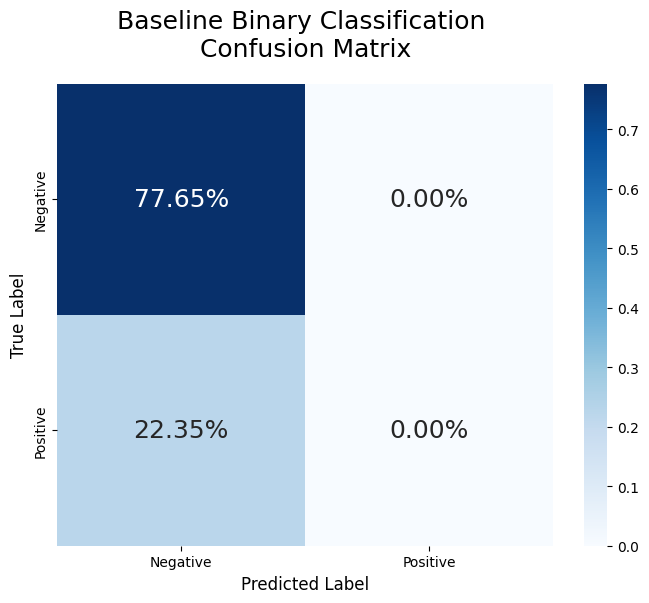

In [16]:
cm = confusion_matrix(y_test, predicted_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            annot_kws={"size": 18})
plt.xlabel('Predicted Label', size=12)
plt.ylabel('True Label', size=12)
plt.title('Baseline Binary Classification \nConfusion Matrix', size=18,
             pad=20)

plt.savefig(path_output_images + 'plot_CM_Binary_Baseline.png', transparent=True)
plt.show()

In [17]:
# Create a DataFrame to easily access the original text
results_df = pd.DataFrame({'text': X_test, 'true_label': y_test, 'predicted_label': predicted_classes})

# True Positives (correctly predicted positive)
true_positives = results_df[(results_df['true_label'] == 1) & (results_df['predicted_label'] == 1)].head(3)
print("True Positives:")
print(true_positives)

# True Negatives (correctly predicted negative)
true_negatives = results_df[(results_df['true_label'] == 0) & (results_df['predicted_label'] == 0)].head(3)
print("\nTrue Negatives:")
print(true_negatives)

# False Positives (incorrectly predicted positive)
false_positives = results_df[(results_df['true_label'] == 0) & (results_df['predicted_label'] == 1)].head(3)
print("\nFalse Positives:")
print(false_positives)

# False Negatives (incorrectly predicted negative)
false_negatives = results_df[(results_df['true_label'] == 1) & (results_df['predicted_label'] == 0)].head(3)
print("\nFalse Negatives:")
false_negatives

True Positives:
Empty DataFrame
Columns: [text, true_label, predicted_label]
Index: []

True Negatives:
                                                   text  true_label  \
3010  How CDC Will Track Viruses Over the Holiday Tr...           0   
4219  Sacramento police stop mother and 8-year-old s...           0   
1132  Noel Gallagher concert canceled over the weeke...           0   

      predicted_label  
3010                0  
4219                0  
1132                0  

False Positives:
Empty DataFrame
Columns: [text, true_label, predicted_label]
Index: []

False Negatives:


,text,true_label,predicted_label
195,MLB Made Dramatic Rule Changes. These All-Star...,1,0
5564,See Jason Momoa in the first trailer for 'Aqua...,1,0
114,Six Exercises to Keep Shoulders Strong and Stable,1,0
